In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [2]:
# Download stopwords if not already present
nltk.download("stopwords")


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sahilnakhate/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Load dataset (ensure the file is in the correct directory)
df = pd.read_csv("twitter_training.csv", encoding="ISO-8859-1")


In [4]:
# Rename columns for clarity
df.columns = ["ID", "Topic", "Sentiment", "Text"]
df = df[["Sentiment", "Text"]]


In [5]:
# Drop missing values
df.dropna(inplace=True)

/var/folders/r3/trn6xwcx7js3_2j79fkcxz880000gn/T/ipykernel_32212/922716684.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["Sentiment"], palette="coolwarm", order=df["Sentiment"].value_counts().index)


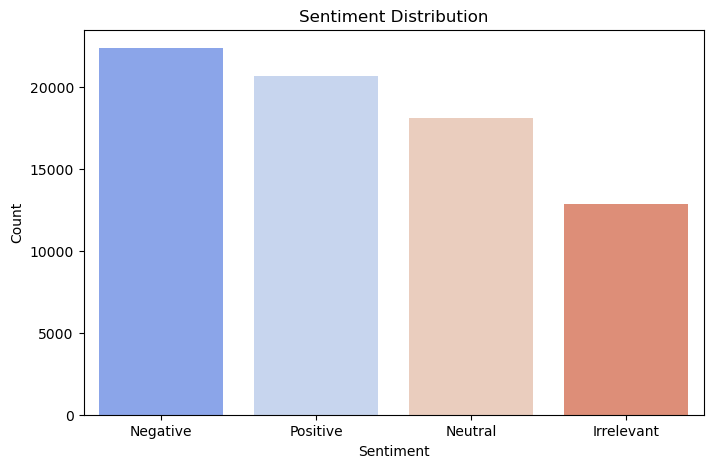

In [6]:
# EDA: Sentiment Distribution
plt.figure(figsize=(8, 5))
sns.countplot(x=df["Sentiment"], palette="coolwarm", order=df["Sentiment"].value_counts().index)
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

In [7]:
# Generate word clouds for each sentiment
sentiments = ["Positive", "Negative", "Neutral"]
wordclouds = {}

In [8]:
for sentiment in sentiments:
    text_data = " ".join(df[df["Sentiment"] == sentiment]["Text"].dropna())
    wordclouds[sentiment] = WordCloud(width=600, height=400, background_color="white").generate(text_data)

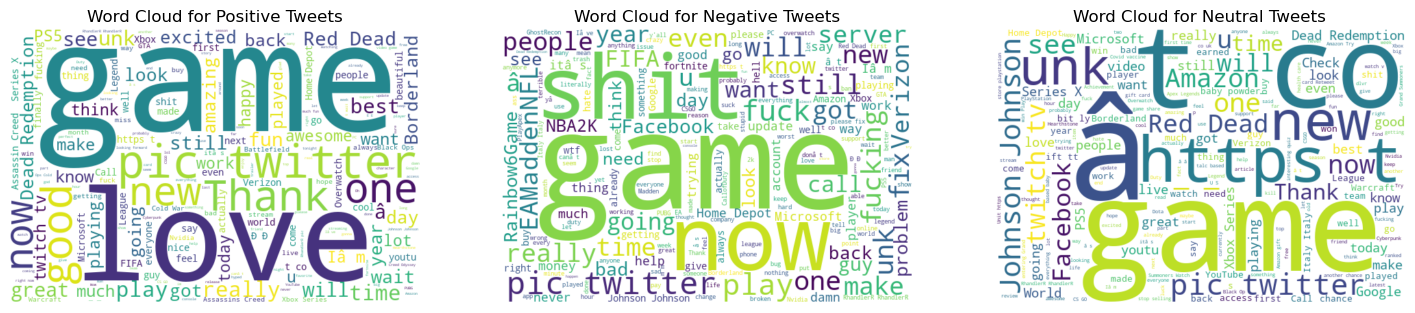

In [9]:
# Plot word clouds
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for i, sentiment in enumerate(sentiments):
    axes[i].imshow(wordclouds[sentiment], interpolation="bilinear")
    axes[i].set_title(f"Word Cloud for {sentiment} Tweets")
    axes[i].axis("off")

In [10]:
plt.show()

In [11]:
# Text Preprocessing Function
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)  # Remove URLs
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    text = " ".join([word for word in text.split() if word not in stopwords.words("english")])
    return text

In [12]:
# Apply text cleaning
df["Cleaned_Text"] = df["Text"].apply(clean_text)

In [13]:
# Encode target labels
df = df[df["Sentiment"].isin(["Positive", "Negative", "Neutral"])]  # Remove "Irrelevant"
df["Sentiment"] = df["Sentiment"].map({"Positive": 1, "Negative": -1, "Neutral": 0})

In [14]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(df["Cleaned_Text"], df["Sentiment"], test_size=0.2, random_state=42, stratify=df["Sentiment"])


In [15]:
# Convert text into numerical features using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [16]:
# Train a Naive Bayes classifier
clf = MultinomialNB()
clf.fit(X_train_tfidf, y_train)


MultinomialNB()

In [17]:
# Predict sentiments
y_pred = clf.predict(X_test_tfidf)

In [18]:
# Model Evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))



Model Accuracy: 0.7176

Classification Report:
               precision    recall  f1-score   support

          -1       0.70      0.81      0.75      4472
           0       0.75      0.56      0.64      3621
           1       0.71      0.76      0.74      4131

    accuracy                           0.72     12224
   macro avg       0.72      0.71      0.71     12224
weighted avg       0.72      0.72      0.71     12224



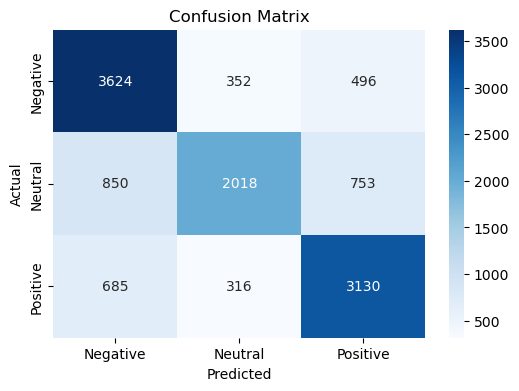

In [19]:
# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Neutral", "Positive"], yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
